In [17]:
import os
import glob
import json
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
def process_folder(folder_path):
    """
    Reads all JSON files in a folder, parses tweet creation times,
    and returns a DataFrame with tweet counts grouped in 6-hour bins.
    """
    records = []
    # Search for all JSON files in the folder
    for file_path in glob.glob(os.path.join(folder_path, "*.json")):
        with open(file_path, 'r', encoding='utf-8') as f:
            tweets = json.load(f)
        for tweet in tweets:
            # Parse the createdAt field into a pandas Timestamp
            created_at = pd.to_datetime(
                tweet['createdAt'],
                utc=True,
                format='%a %b %d %H:%M:%S %z %Y'
            )
            # Floor to the nearest 6-hour period
            period = created_at.floor('6H')
            records.append({'period': period})

    # Build DataFrame and count tweets per period
    df = pd.DataFrame(records)
    df_counts = df.groupby('period').size().reset_index(name='count')
    return df_counts


# Define paths to your two folders
folder1 = r"Apify_Tweets/to with at"
folder2 = r"Apify_Tweets/to you -with at"

# Process each folder separately
df_with_at = process_folder(folder1)
df_you_at  = process_folder(folder2)

C:\Users\pryty\AppData\Local\Temp\ipykernel_12364\3584273326.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  period = created_at.floor('6H')
C:\Users\pryty\AppData\Local\Temp\ipykernel_12364\3584273326.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  period = created_at.floor('6H')


In [24]:
# Merge the two DataFrames on the period column
df_merged = pd.merge(
    df_with_at,
    df_you_at,
    on='period',
    how='outer',
    suffixes=('_with_at', '_you_at')
)
# Fill missing counts with 0 and sort by time
df_merged = df_merged.fillna(0).sort_values('period')

# Compute the average tweet count across both datasets
df_merged['average'] = df_merged[['count_with_at', 'count_you_at']].mean(axis=1)

# Compute a 7-period rolling average on the 'average' column
df_merged['rolling_average_7'] = df_merged['average'].rolling(window=7, min_periods=1).mean()

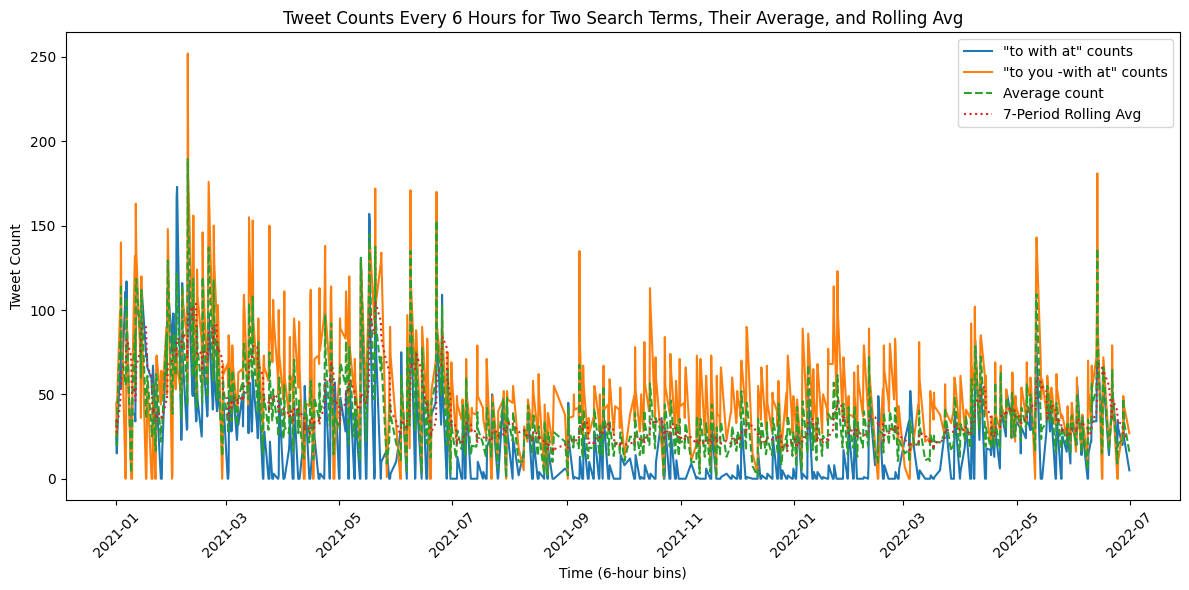

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(
    df_merged['period'],
    df_merged['count_with_at'],
    label='"to with at" counts'
)
plt.plot(
    df_merged['period'],
    df_merged['count_you_at'],
    label='"to you -with at" counts'
)
plt.plot(
    df_merged['period'],
    df_merged['average'],
    linestyle='--',
    label='Average count'
)
# Add rolling average to the plot
plt.plot(
    df_merged['period'],
    df_merged['rolling_average_7'],
    linestyle=':',
    label='7-Period Rolling Avg'
)
plt.xlabel('Time (6-hour bins)')
plt.ylabel('Tweet Count')
plt.title('Tweet Counts Every 6 Hours for Two Search Terms, Their Average, and Rolling Avg')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
# Ensure 'period' is the index for time-based operations
df_merged.set_index('period', inplace=True)

# Compute a 7-day rolling average on the 'average' column
# Using a time-based window of 7 days
df_merged['rolling_avg_7d'] = df_merged['average'].rolling('7D', min_periods=1).mean()

# Reindex to include every 6-hour period between min and max dates
tz = df_merged.index.tz
full_index = pd.date_range(
    start=df_merged.index.min(),
    end=df_merged.index.max(),
    freq='6H',
    tz=tz
)
df_merged = df_merged.reindex(full_index).fillna(0)
df_merged.index.name = 'period'

C:\Users\pryty\AppData\Local\Temp\ipykernel_12364\2359569770.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_index = pd.date_range(


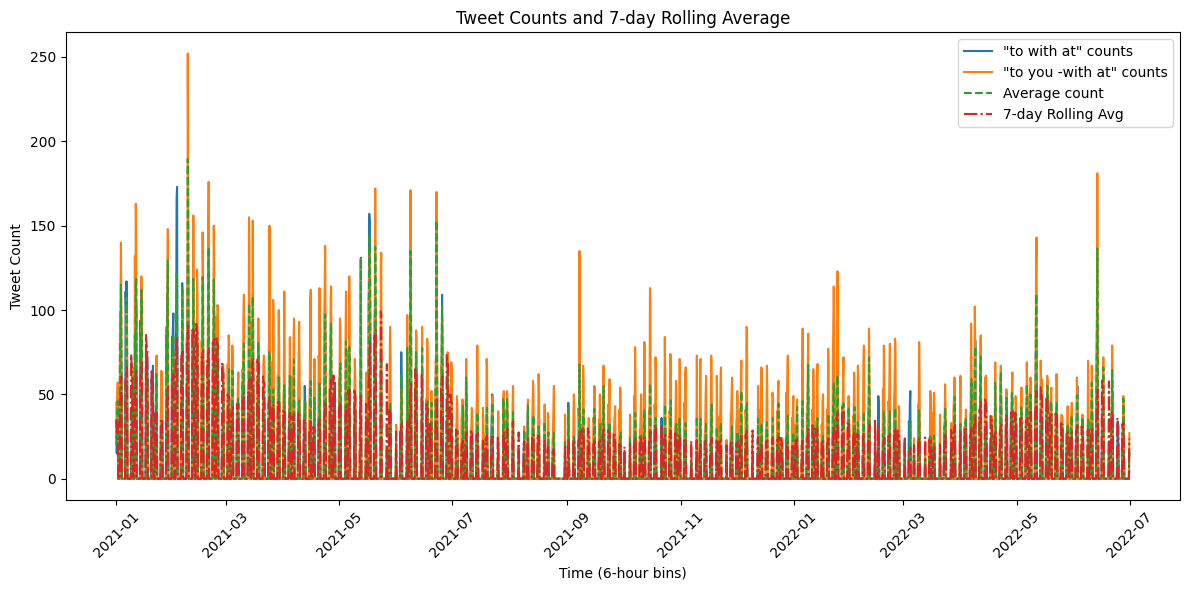

In [22]:
# Plot including the 7-day rolling average
plt.figure(figsize=(12, 6))
plt.plot(df_merged.index, df_merged['count_with_at'], label='"to with at" counts')
plt.plot(df_merged.index, df_merged['count_you_at'], label='"to you -with at" counts')
plt.plot(df_merged.index, df_merged['average'], linestyle='--', label='Average count')
plt.plot(df_merged.index, df_merged['rolling_avg_7d'], linestyle='-.', label='7-day Rolling Avg')
plt.xlabel('Time (6-hour bins)')
plt.ylabel('Tweet Count')
plt.title('Tweet Counts and 7-day Rolling Average')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [23]:
df_merged

,count_with_at,count_you_at,average,rolling_avg_7d
period,,,,
2021-01-01 00:00:00+00:00,25.0,45.0,35.0,35.0000
2021-01-01 06:00:00+00:00,15.0,25.0,20.0,27.5000
2021-01-01 12:00:00+00:00,22.0,45.0,33.5,29.5000
2021-01-01 18:00:00+00:00,35.0,57.0,46.0,33.6250
2021-01-02 00:00:00+00:00,0.0,0.0,0.0,0.0000
...,...,...,...,...
2022-06-29 18:00:00+00:00,0.0,0.0,0.0,0.0000
2022-06-30 00:00:00+00:00,0.0,0.0,0.0,0.0000
2022-06-30 06:00:00+00:00,0.0,0.0,0.0,0.0000
